# Estimation de la profondeur dans une image 2D

## Etape 1 : Importation des modules

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from transformers import pipeline

## Etape 2 : Utilisation d'estimation de profondeur avec l'API de PIL

Dans ce cas, nous utilisons un modèle de fondation cependant celui-ci a déjà été entraîné et fine-tuned (affiné). Cela permet d'enlever toute la complexité et garder uniquement le nécessaire c'ets-à-dire quelle est l'image qu'on veut estimer, sans même parler de dataset. Tout est déjà effectué.

### Etape 2.1 : Chargement de pipe

In [5]:
# load the pipe
pipe = pipeline(task='depth-estimation', model='depth-anything/Depth-Anything-V2-Large-hf')

ValueError: Pipeline cannot infer suitable model classes from depth-anything/Depth-Anything-V2-Large-hf

### Etape 2.2 : Chargement de l'image

In [3]:
# load image
image = Image.open('boat.JPG')

### Etape 2.3 : Inférence puis affichage de l'estimation

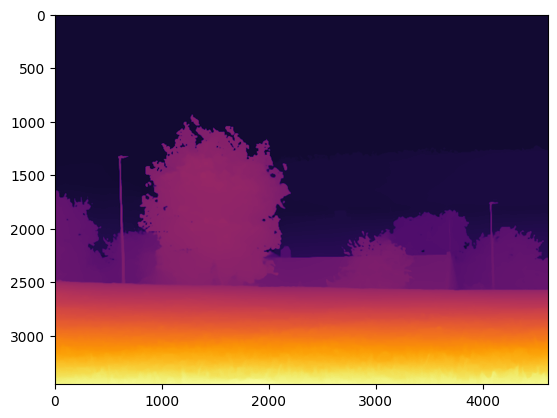

In [5]:
# inference
depth = pipe(image)["depth"]

plt.imshow(depth, cmap='inferno')
plt.show()

## Etape 3 : Utilisation d'estimation de profondeur en utilisant le modèle de fondation.

Nous allons cette fois-ci utiliser le modèle de fondation directement, les étapes seront donc légèrement plus compliquées cependant nous aurons davantage de contrôle sur ce que nous voulons faire avec le modèle.

### Etape 3.1 : Importation des modules

In [5]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
import requests

### Etape 3.2 : Chargement de l'image

In [ ]:
# load image
image = Image.open('boat.JPG')

### Etape 3.3 : Définition du processeur de l'image et du modèle

In [6]:
image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")

### Etape 3.4 : Préparation de l'image pour le modèle

In [8]:
inputs = image_processor(images=image, return_tensors="pt")

In [9]:
with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)]
)

### Etape 3.5 : Estimation de la profondeur et affichage du résultat

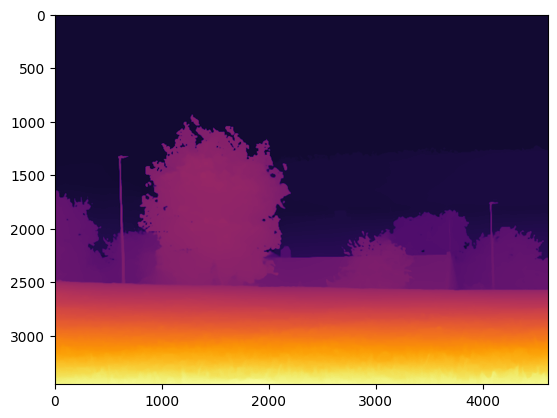

In [11]:
predicted_depth = post_processed_output[0]["predicted_depth"]
depth = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())
depth = depth.detach().cpu().numpy() * 255
depth = Image.fromarray(depth.astype("uint8"))

plt.imshow(depth, cmap='inferno')
plt.show()

## Etape 4 : Application sur notre dataset

Nous avons un dataset d'images satellites, nous aimerions appliquer notre estimateur de profondeur sur nos images satellites pour pouvoir détecter le relief

### Etape 4.1 : Chargement du dataset

In [9]:
import datasets

ds = datasets.load_dataset("satellite-image-deep-learning/DOTAv2")

A

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1054x1529 at 0x2AAF3976790>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1539x2319 at 0x2AAF37EBA90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1179x967 at 0x2AAF38A15D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1616x1565 at 0x2AAF3AFFF90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=873x1434 at 0x2AAF3E43F50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2421x5353 at 0x2AAF5A03FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2319x3369 at 0x2AAF7317F90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3195x4348 at 0x2AAF76B3F90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3819x2547 at 0x2AAFBE07F50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=5343x3795 at 0x2AAFC44FF90>


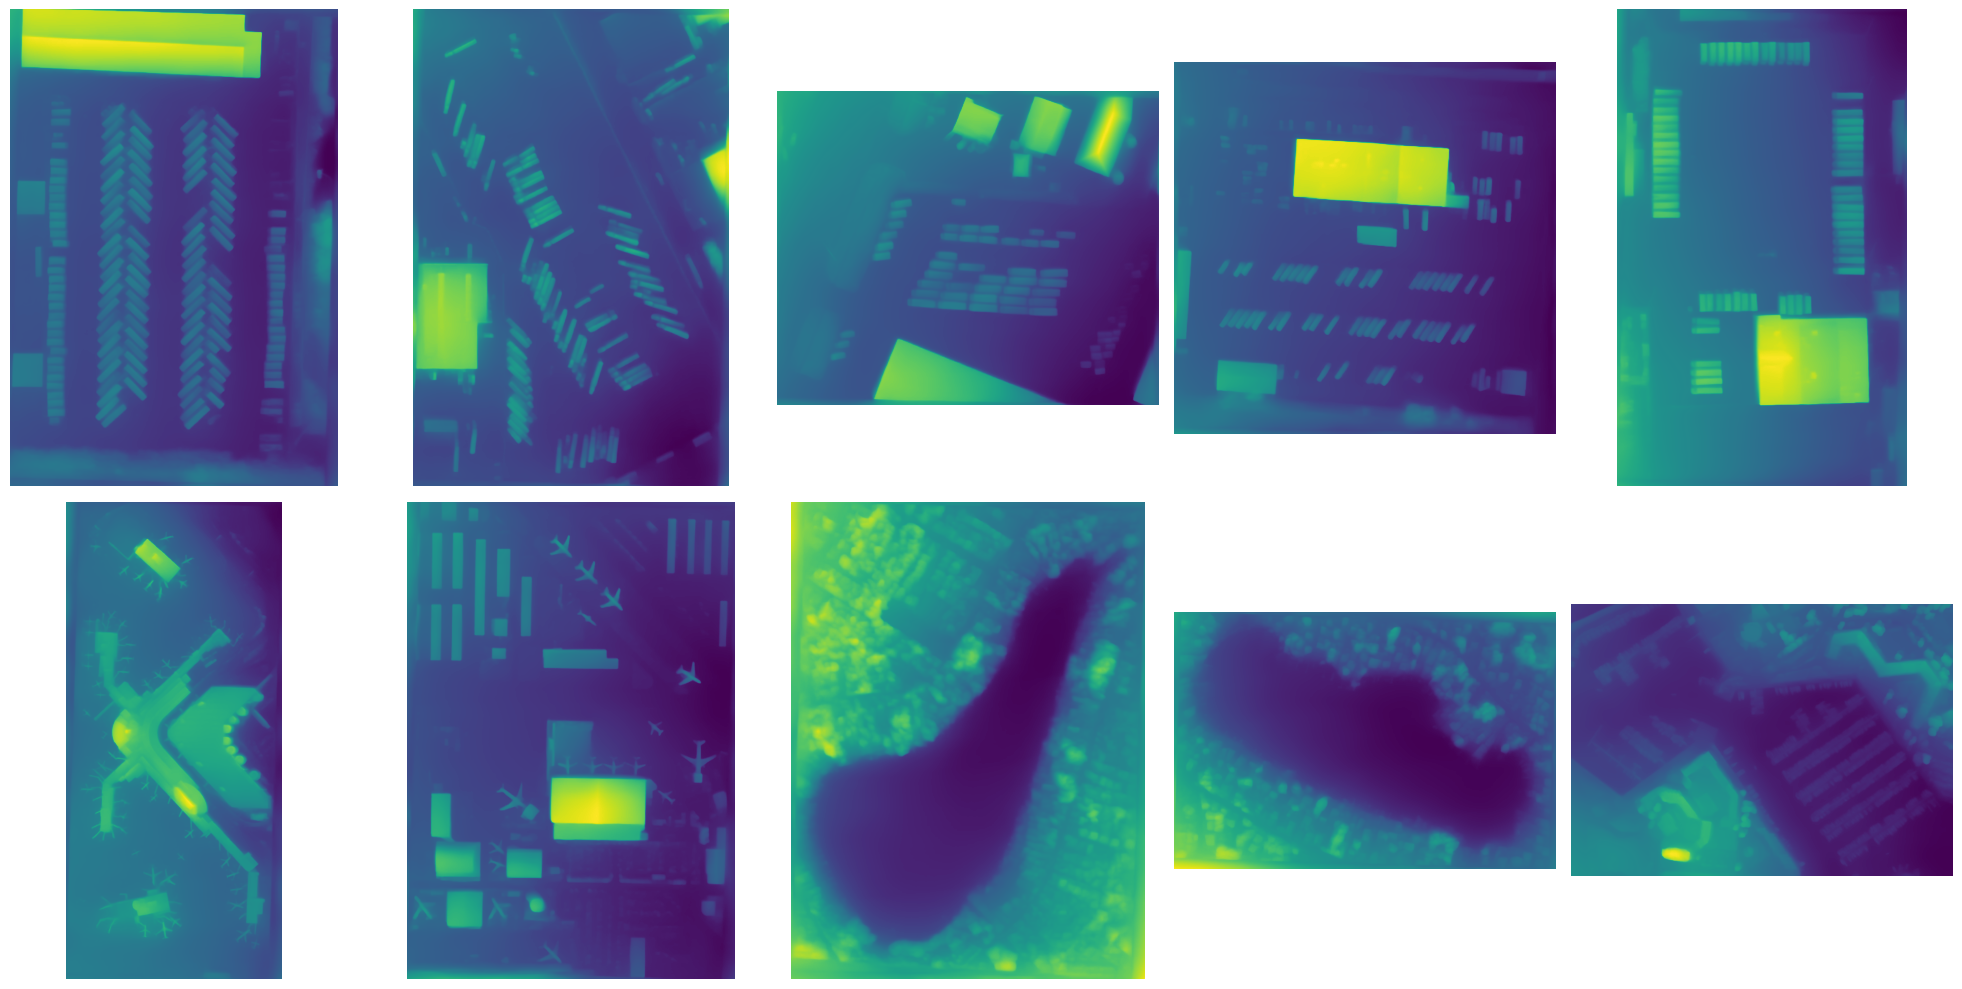

In [10]:
data = ds["train"]
depth_images = []

fix, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    current_image = data[i]["image"]
    print(current_image)
    

    inputs = image_processor(images=current_image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    post_processed_output = image_processor.post_process_depth_estimation(
        outputs,
    )

    predicted_depth = post_processed_output[0]["predicted_depth"]
    depth = (predicted_depth - predicted_depth.min()) / (predicted_depth.max() - predicted_depth.min())
    depth = depth.detach().cpu().numpy() * 255
    depth = Image.fromarray(depth.astype("uint8"))

    depth_images.append(depth)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(depth_images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

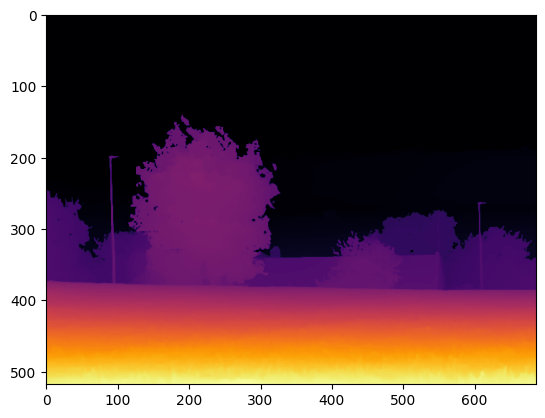

In [7]:
image_boat = Image.open('boat.JPG')

inputs_boat = image_processor(images=image_boat, return_tensors="pt")

with torch.no_grad():
    outputs_boat = model(**inputs_boat)

post_processed_output_boat = image_processor.post_process_depth_estimation(
    outputs_boat,
)

predicted_depth_boat = post_processed_output_boat[0]["predicted_depth"]
depth_boat = (predicted_depth_boat - predicted_depth_boat.min()) / (predicted_depth_boat.max() - predicted_depth_boat.min())
depth_boat = depth_boat.detach().cpu().numpy() * 255
depth_boat = Image.fromarray(depth_boat.astype("uint8"))

plt.imshow(depth_boat, cmap='inferno')
plt.show()